In [1]:
import copy
import lmfit
import numpy as np
import matplotlib.pyplot as plt
from rich.progress import Progress
from scipy.stats import binned_statistic
from utils.plot_utils import set_fontsize
from utils.hdf_utils import load_measurement_data_devices_attrs

In [10]:
fname = "2021_2_2.hdf"
dset_names = [
    "1612309421 saturation scan 20.2 mW",
    "1612307912 saturation scan 30.3 mW",
    "1612306124 saturation scan 50.4 mW",
]

powers = [
    20.2, 30.3, 50.4
]
devices = ()

In [3]:
yag_channel = 0
pmt_channel = 1
pd_channel = 2
pdn_channel = 3

dset_len = 2000
nbunch = 10

freq_attr = "Laser Lock SetLockPointSeed2"

In [44]:
bin_fun = lambda x: np.nanmean(x)
bins = np.arange(-362, -351,1)
scan_data = dict([(p, []) for p in powers])
scan_data_normalized = dict([(p, []) for p in powers])

# +/- how many times std to accept
absorption_cutoff = 2
                
with Progress() as progress:
    task = progress.add_task("[green]Processing...", total = len(powers))
    for power, dset_name in zip(powers, dset_names):
        pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(fname, dset_name, devices)

        freq_data = np.array([pxie_attrs[idx][freq_attr] for idx in range(1,len(pxie)+1)])

        yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
        pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
        pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
        pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
        norm_data = -pd_data/pdn_data

        pmt_data[np.where(yag_data.max(axis = 1) < 500)[0]] = np.nan
        norm_data[np.where(yag_data.max(axis = 1) < 500)[0]] = np.nan

        pmt_data_avg = np.nanmean(pmt_data.reshape(-1,nbunch,dset_len), axis = 1)
        norm_data_avg = np.nanmean(norm_data.reshape(-1,nbunch,dset_len), axis = 1)

        pmt_data_avg -= pmt_data_avg[:,100:250].mean(axis = 1)[:,np.newaxis]
        norm_data_avg -= norm_data_avg[:,-750:].mean(axis = 1)[:,np.newaxis]

        freq_data_avg = freq_data.reshape(-1,nbunch).mean(axis = 1)

        fluorescence_integral = np.trapz(pmt_data_avg[:,100:], axis = 1)
        absorption_integral = np.trapz(norm_data_avg[:,10:1250], axis = 1)
        
        absorption_cutoff = 1
        mean = np.nanmean(absorption_integral)
        std = np.nanstd(absorption_integral)
        mask_absorption = (absorption_integral > mean - absorption_cutoff*std) \
                            & (absorption_integral < mean + absorption_cutoff*std)

        stat, bin_edges, bin_number = binned_statistic(
                                            freq_data_avg[mask_absorption], 
                                            fluorescence_integral[mask_absorption]/absorption_integral[mask_absorption], 
                                            statistic = bin_fun, 
                                            bins = bins)
        
        err, _, _ = binned_statistic(
                                            freq_data_avg[mask_absorption], 
                                            fluorescence_integral[mask_absorption]/absorption_integral[mask_absorption], 
                                            statistic = lambda x: np.nanstd(x)/np.sqrt(len(x)), 
                                            bins = bins)

        bin_means = bin_edges[:-1]+np.diff(bin_edges)[0]

        scan_data_normalized[power] = (bin_means, stat, err)
        
        stat, bin_edges, bin_number = binned_statistic(
                                            freq_data_avg[mask_absorption], 
                                            fluorescence_integral[mask_absorption], 
                                            statistic = bin_fun, 
                                            bins = bins)
        
        err, _, _ = binned_statistic(
                                            freq_data_avg[mask_absorption], 
                                            fluorescence_integral[mask_absorption], 
                                            statistic = lambda x: np.nanstd(x)/np.sqrt(len(x)), 
                                            bins = bins)

        bin_means = bin_edges[:-1]+np.diff(bin_edges)[0]

        scan_data[power] = (bin_means, stat, err)
        
        progress.update(task, advance = 1)
        progress.refresh()

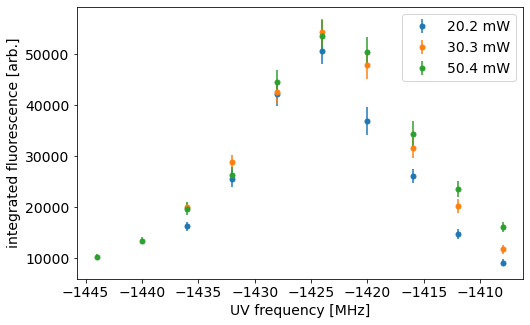

In [45]:
fig, ax = plt.subplots(figsize = (8,5))

for power in sorted(powers):
    bins, values, err = scan_data[power]
    ax.errorbar(4*bins, values, yerr = err, fmt = '.', label = f'{power:.1f} mW', ms = 10)

    ax.legend(fontsize = 14)
    
ax.set_xlabel('UV frequency [MHz]')
ax.set_ylabel('integrated fluorescence [arb.]')

set_fontsize(ax, 14)

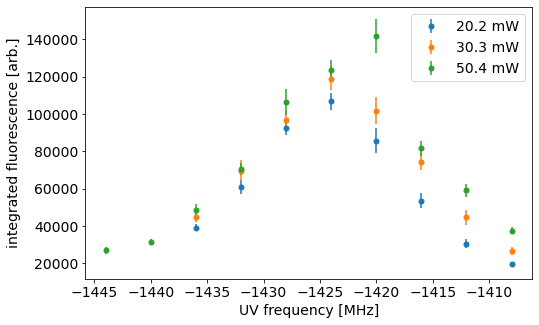

In [46]:
fig, ax = plt.subplots(figsize = (8,5))

for power in sorted(powers):
    bins, values, err = scan_data_normalized[power]
    ax.errorbar(4*bins, values, yerr = err, fmt = '.', label = f'{power:.1f} mW', ms = 10)

    ax.legend(fontsize = 14)
    
ax.set_xlabel('UV frequency [MHz]')
ax.set_ylabel('integrated fluorescence [arb.]')

set_fontsize(ax, 14)

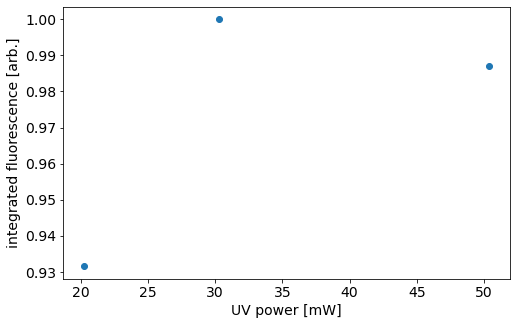

In [40]:
# this only works because I know the central value in maximal (from the plots above)
# use indexing to be sure to grab the central value when this is not the case
central_value = [np.nanmax(scan_data[power][1]) for power in powers]

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(powers, central_value/max(central_value), '.', ms = 12)

ax.set_xlabel('UV power [mW]')
ax.set_ylabel('integrated fluorescence [arb.]')
set_fontsize(ax, 14)

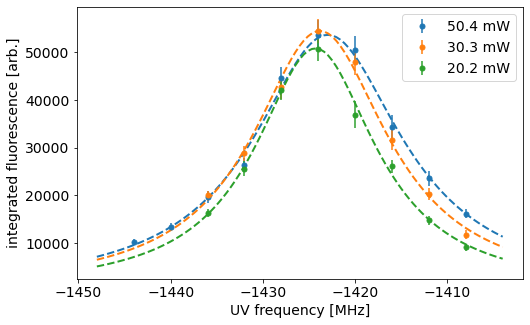

In [17]:
fit_model = lmfit.models.LorentzianModel()
params = fit_model.make_params()

x = np.linspace(-362,-351,101)*4

fits = {}

fig, ax = plt.subplots(figsize = (8,5))
for idx, power in enumerate(sorted(powers)[::-1]):
    bins, values, err = scan_data[power]
    bins = 4*bins
    
    params.add('amplitude', np.nanmax(values))
    params.add('center', bins[np.nanargmax(values)])

    mask_notnan = ~np.isnan(values)
    result = fit_model.fit(values[mask_notnan], 
                           params, 
                           weights = 1/err[mask_notnan],
                           x = bins[mask_notnan])
    
    ax.plot(x, result.eval(x = x), color = f'C{idx}', ls = '--', lw = 2)
    ax.errorbar(bins, values, yerr = err, 
                ms = 10, fmt = '.', ecolor = f'C{idx}', color = f'C{idx}',
                label = f'{power:.1f} mW'
               )
    
    fits[power] = result
    
ax.set_xlabel('UV frequency [MHz]')
ax.set_ylabel('integrated fluorescence [arb.]')
ax.legend(fontsize = 14)

set_fontsize(ax, 14)

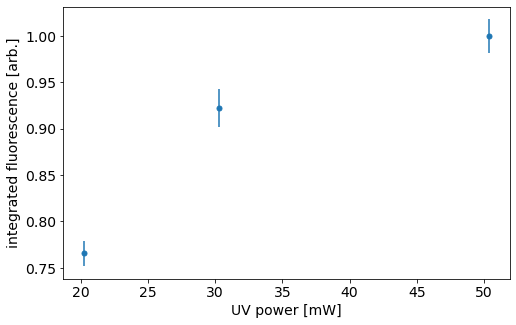

In [18]:
y = np.array([fits[power].params['amplitude'].value for power in powers])
yerr = np.array([fits[power].params['amplitude'].stderr for power in powers])/y.max()

y /= y.max()

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(powers, y, yerr = yerr, fmt = '.', ms = 10)

ax.set_xlabel('UV power [mW]')
ax.set_ylabel('integrated fluorescence [arb.]')
set_fontsize(ax, 14)

## Fit same μ for all datasets

In [19]:
from lmfit import minimize, Parameters

In [20]:
l = lmfit.models.LorentzianModel()

In [21]:
def lorentzian(x, A, μ, σ):
    return A/np.pi * ( σ / ((x-μ)**2+σ**2) )

In [22]:
def lorentzian_dataset(params, idx, x):
    A = params[f'A_{idx}'].value
    μ = params[f'μ_{idx}'].value
    σ = params[f'σ_{idx}'].value
    return l.func(x, A, μ, σ)

In [23]:
def objective(params, x, data, weights):
    """ calculate total residual for fits to several data sets held
    in a 2-D array, and modeled by Gaussian functions"""
    ndata, nx = data.shape
    resid = 0.0*data[:]
    # make residual per data set
    for i in range(ndata):
        resid[i, :] = (data[i, :] - lorentzian_dataset(params, i, x)) * weights[i, :]
    # now flatten this to a 1D array, as minimize() needs
    return resid.flatten()

In [33]:
def global_fit(scan_data):
    freq_range = (-359,-352)
    data = []
    weights = []
    for power in sorted(powers):
        freqs, values, errors = scan_data[power]
        m = (freqs >= freq_range[0]) & (freqs <= freq_range[1])
        data.append(values[m])
        weights.append(1/errors[m])

    data = np.asarray(data)
    weights = np.asarray(weights)
    freqs = freqs[m]*4
    
    σ_estimate = 2
    fit_params = Parameters()

    for idx, y in enumerate(data):
        fit_params.add( f'A_{idx}', value = np.max(data[idx,:]))
        fit_params.add( f'μ_{idx}', value = freqs[np.argmax(data[idx,:])])
        fit_params.add( f'σ_{idx}', value = σ_estimate)

    for idx in range(1,len(data)):
        fit_params[f'μ_{idx}'].expr='μ_0'
        
    result = minimize(objective, fit_params, args=(freqs, data, weights))
    
    return freqs, data, weights, result

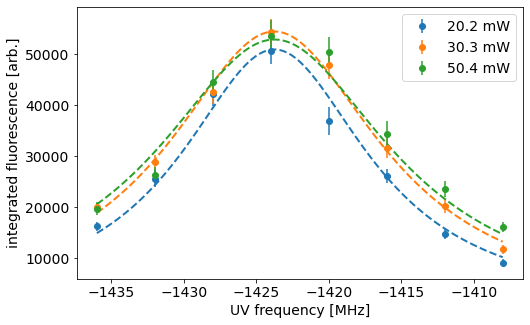

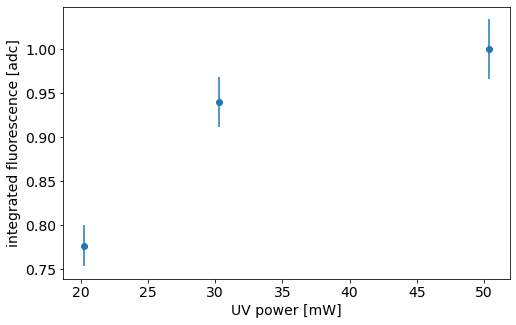

In [34]:
freqs, data, weights, result = global_fit(scan_data)

x = np.linspace(min(freqs),max(freqs), 101)

fig, ax = plt.subplots(figsize = (8,5))
for idx in range(len(data)):
    ax.errorbar(freqs, data[idx,:], yerr = 1/weights[idx,:], 
                fmt = '.', ms = 12, color = f'C{idx}',
                label = f'{sorted(powers)[idx]:.1f} mW')
    ax.plot(x, lorentzian_dataset(result.params, idx, x), color = f'C{idx}', ls ='--', lw = 2)
    
ax.set_xlabel('UV frequency [MHz]')
ax.set_ylabel('integrated fluorescence [arb.]')
ax.legend(fontsize = 14)

set_fontsize(ax, 14)

y = np.array([result.params[f'A_{idx}'].value for idx in range(len(data))])
yerr = np.array([result.params[f'A_{idx}'].stderr for idx in range(len(data))])/y.max()

y /= y.max()

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(sorted(powers), y, yerr = yerr, fmt = '.', ms = 12)

ax.set_xlabel('UV power [mW]')
ax.set_ylabel('integrated fluorescence [adc]')
set_fontsize(ax, 14)

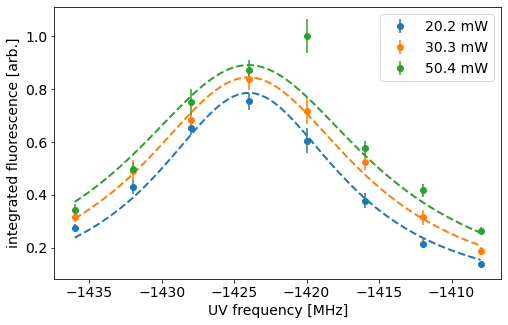

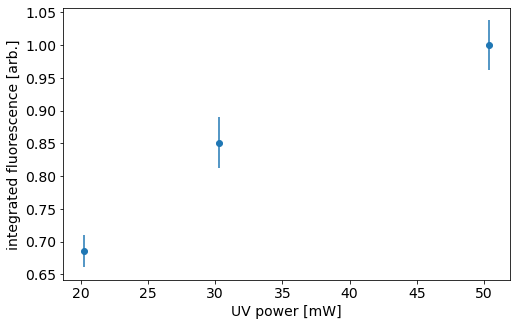

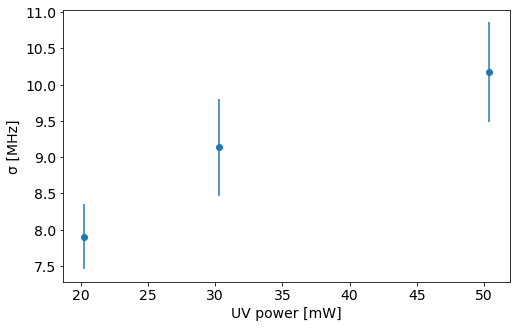

In [35]:
freqs, data, weights, result = global_fit(scan_data_normalized)

max_data = np.max(data)
data /= np.max(data)

x = np.linspace(min(freqs),max(freqs), 101)

fig, ax = plt.subplots(figsize = (8,5))
for idx in range(len(data)):
    ax.errorbar(freqs, data[idx,:], yerr = 1/weights[idx,:] / max_data, 
                fmt = '.', ms = 12, color = f'C{idx}',
                label = f'{sorted(powers)[idx]:.1f} mW')
    ax.plot(x, lorentzian_dataset(result.params, idx, x)/max_data, color = f'C{idx}', ls ='--', lw = 2)
    
ax.set_xlabel('UV frequency [MHz]')
ax.set_ylabel('integrated fluorescence [arb.]')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

y = np.array([result.params[f'A_{idx}'].value for idx in range(len(data))])
yerr = np.array([result.params[f'A_{idx}'].stderr for idx in range(len(data))])/y.max()

y /= y.max()

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(sorted(powers), y, yerr = yerr, fmt = '.', ms = 12)

ax.set_xlabel('UV power [mW]')
ax.set_ylabel('integrated fluorescence [arb.]')
set_fontsize(ax, 14)

y = np.array([result.params[f'σ_{idx}'].value for idx in range(len(data))])
yerr = np.array([result.params[f'σ_{idx}'].stderr for idx in range(len(data))])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(sorted(powers), y, yerr = yerr, fmt = '.', ms = 12)

ax.set_xlabel('UV power [mW]')
ax.set_ylabel('σ [MHz]')
set_fontsize(ax, 14)

## Moved DET slightly down

In [47]:
dset_names = [
    "1612310869 moved det down a bit saturation scan 20.2 mW",
    "1612312372 moved det down a bit saturation scan 50 mW",
    "1612313695 moved det down a bit saturation scan 30 mW",
]

powers = [
    20.2, 50, 30
]
devices = ()

In [48]:
bin_fun = lambda x: np.nanmean(x)
bins = np.arange(-362, -351,1)
scan_data = dict([(p, []) for p in powers])
scan_data_normalized = dict([(p, []) for p in powers])

# +/- how many times std to accept
absorption_cutoff = 1
                
with Progress() as progress:
    task = progress.add_task("[green]Processing...", total = len(powers))
    for power, dset_name in zip(powers, dset_names):
        pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(fname, dset_name, devices)

        freq_data = np.array([pxie_attrs[idx][freq_attr] for idx in range(1,len(pxie)+1)])

        yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
        pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
        pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
        pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
        norm_data = -pd_data/pdn_data

        pmt_data[np.where(yag_data.max(axis = 1) < 500)[0]] = np.nan
        norm_data[np.where(yag_data.max(axis = 1) < 500)[0]] = np.nan

        pmt_data_avg = np.nanmean(pmt_data.reshape(-1,nbunch,dset_len), axis = 1)
        norm_data_avg = np.nanmean(norm_data.reshape(-1,nbunch,dset_len), axis = 1)

        pmt_data_avg -= pmt_data_avg[:,100:250].mean(axis = 1)[:,np.newaxis]
        norm_data_avg -= norm_data_avg[:,-750:].mean(axis = 1)[:,np.newaxis]

        freq_data_avg = freq_data.reshape(-1,nbunch).mean(axis = 1)

        fluorescence_integral = np.trapz(pmt_data_avg[:,100:], axis = 1)
        absorption_integral = np.trapz(norm_data_avg[:,10:1250], axis = 1)
        
        absorption_cutoff = 1
        mean = np.nanmean(absorption_integral)
        std = np.nanstd(absorption_integral)
        mask_absorption = (absorption_integral > mean - absorption_cutoff*std) \
                            & (absorption_integral < mean + absorption_cutoff*std)

        stat, bin_edges, bin_number = binned_statistic(
                                            freq_data_avg[mask_absorption], 
                                            fluorescence_integral[mask_absorption]/absorption_integral[mask_absorption], 
                                            statistic = bin_fun, 
                                            bins = bins)
        
        err, _, _ = binned_statistic(
                                            freq_data_avg[mask_absorption], 
                                            fluorescence_integral[mask_absorption]/absorption_integral[mask_absorption], 
                                            statistic = lambda x: np.nanstd(x)/np.sqrt(len(x)), 
                                            bins = bins)

        bin_means = bin_edges[:-1]+np.diff(bin_edges)[0]

        scan_data_normalized[power] = (bin_means, stat, err)
        
        stat, bin_edges, bin_number = binned_statistic(
                                            freq_data_avg[mask_absorption], 
                                            fluorescence_integral[mask_absorption], 
                                            statistic = bin_fun, 
                                            bins = bins)
        
        err, _, _ = binned_statistic(
                                            freq_data_avg[mask_absorption], 
                                            fluorescence_integral[mask_absorption], 
                                            statistic = lambda x: np.nanstd(x)/np.sqrt(len(x)), 
                                            bins = bins)

        bin_means = bin_edges[:-1]+np.diff(bin_edges)[0]

        scan_data[power] = (bin_means, stat, err)
        
        progress.update(task, advance = 1)
        progress.refresh()

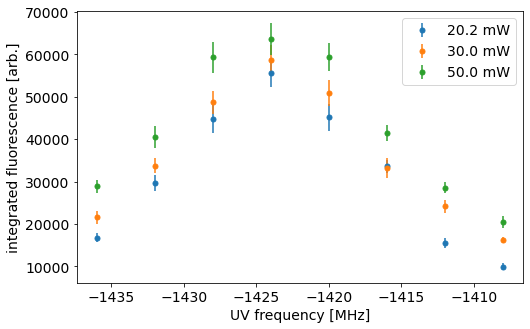

In [49]:
fig, ax = plt.subplots(figsize = (8,5))

for power in sorted(powers):
    bins, values, err = scan_data[power]
    ax.errorbar(4*bins, values, yerr = err, fmt = '.', label = f'{power:.1f} mW', ms = 10)

    ax.legend(fontsize = 14)
    
ax.set_xlabel('UV frequency [MHz]')
ax.set_ylabel('integrated fluorescence [arb.]')

set_fontsize(ax, 14)

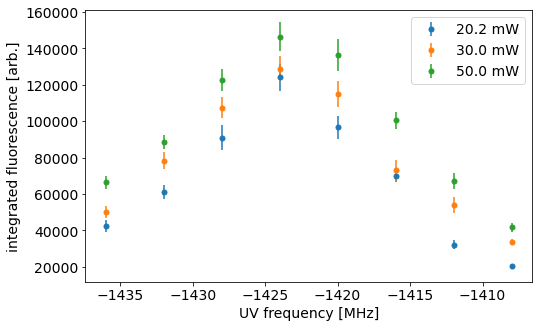

In [56]:
fig, ax = plt.subplots(figsize = (8,5))

for power in sorted(powers):
    bins, values, err = scan_data_normalized[power]
    ax.errorbar(4*bins, values, yerr = err, fmt = '.', label = f'{power:.1f} mW', ms = 10)

    ax.legend(fontsize = 14)
    
ax.set_xlabel('UV frequency [MHz]')
ax.set_ylabel('integrated fluorescence [arb.]')

set_fontsize(ax, 14)

## Move further down

In [59]:
det_name = "1612315229 moved det down even lower saturation scan 30 mW"

In [60]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(fname, dset_name, devices)

freq_data = np.array([pxie_attrs[idx][freq_attr] for idx in range(1,len(pxie)+1)])

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
norm_data = -pd_data/pdn_data

In [61]:
pmt_data[np.where(yag_data.max(axis = 1) < 500)[0]] = np.nan
norm_data[np.where(yag_data.max(axis = 1) < 500)[0]] = np.nan

pmt_data_avg = np.nanmean(pmt_data.reshape(-1,nbunch,dset_len), axis = 1)
norm_data_avg = np.nanmean(norm_data.reshape(-1,nbunch,dset_len), axis = 1)

pmt_data_avg -= pmt_data_avg[:,100:250].mean(axis = 1)[:,np.newaxis]
norm_data_avg -= norm_data_avg[:,-750:].mean(axis = 1)[:,np.newaxis]

freq_data_avg = freq_data.reshape(-1,nbunch).mean(axis = 1)

fluorescence_integral = np.trapz(pmt_data_avg[:,100:], axis = 1)
absorption_integral = np.trapz(norm_data_avg[:,10:1250], axis = 1)

Text(0.5, 0, 'uv frequency [MHz]')

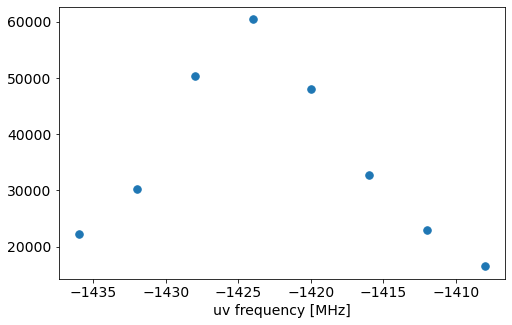

In [71]:
bin_fun = lambda x: np.nanmean(x)
bins = np.arange(-362,351,1)
stat, bin_edges, bin_number = binned_statistic(freq_data_avg, fluorescence_integral, statistic = bin_fun, bins = bins)

bin_means = bin_edges[:-1]+np.diff(bin_edges)[0]

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(bin_means*4, stat, '.', ms = 15)
set_fontsize(ax, 14)
ax.set_xlabel('uv frequency [MHz]')

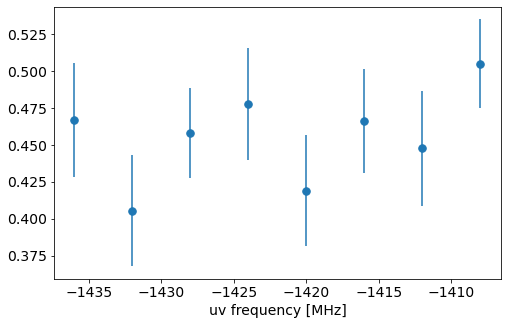

In [72]:
stat, bin_edges, bin_number = binned_statistic(freq_data_avg, absorption_integral, statistic = bin_fun, bins = bins)
std, bin_edges, bin_number = binned_statistic(freq_data_avg, absorption_integral, statistic = lambda x: np.nanstd(x)/np.sqrt(len(x)), bins = bins)

bin_means = bin_edges[:-1]+np.diff(bin_edges)[0]

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means*4, stat, yerr = std, fmt = '.', ms = 15)
ax.set_xlabel('uv frequency [MHz]')

set_fontsize(ax, 14)

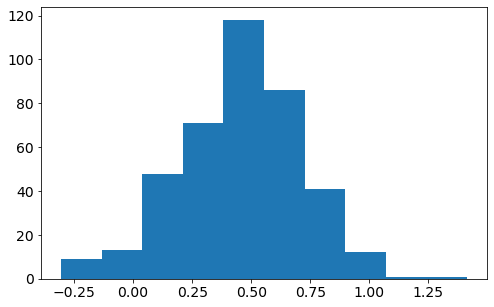

In [73]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hist(absorption_integral)
set_fontsize(ax, 14)

In [74]:
absorption_cutoff = 1
mean = np.nanmean(absorption_integral)
std = np.nanstd(absorption_integral)
mask_absorption = (absorption_integral > mean - absorption_cutoff*std) \
                    & (absorption_integral < mean + absorption_cutoff*std)

print(f"filtered out {100 - mask_absorption.sum()/len(mask_absorption)*100:.2f}%")

filtered out 31.50%


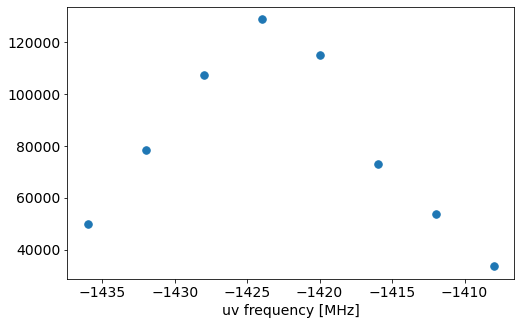

In [75]:
bin_fun = lambda x: np.nanmean(x)
stat, bin_edges, bin_number = binned_statistic(freq_data_avg[mask_absorption], 
                                               fluorescence_integral[mask_absorption]/absorption_integral[mask_absorption], 
                                               statistic = bin_fun, 
                                               bins = bins)

bin_means = bin_edges[:-1]+np.diff(bin_edges)[0]

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(bin_means*4, stat, '.', ms = 15)

ax.set_xlabel('uv frequency [MHz]')
set_fontsize(ax, 14)

## Move DET back to center

In [76]:
dset_names = [
    "1612316575 moved det to center saturation scan 30 mW",
    "1612318033 moved det to center saturation scan 40.4 mW",
    "1612319492 moved det to center saturation scan 19.4 mW",
]

powers = [
    30, 40.4, 19.4
]
devices = ()

In [77]:
bin_fun = lambda x: np.nanmean(x)
bins = np.arange(-362, -351,1)
scan_data = dict([(p, []) for p in powers])
scan_data_normalized = dict([(p, []) for p in powers])

# +/- how many times std to accept
absorption_cutoff = 1
                
with Progress() as progress:
    task = progress.add_task("[green]Processing...", total = len(powers))
    for power, dset_name in zip(powers, dset_names):
        pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(fname, dset_name, devices)

        freq_data = np.array([pxie_attrs[idx][freq_attr] for idx in range(1,len(pxie)+1)])

        yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
        pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
        pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
        pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
        norm_data = -pd_data/pdn_data

        pmt_data[np.where(yag_data.max(axis = 1) < 500)[0]] = np.nan
        norm_data[np.where(yag_data.max(axis = 1) < 500)[0]] = np.nan

        pmt_data_avg = np.nanmean(pmt_data.reshape(-1,nbunch,dset_len), axis = 1)
        norm_data_avg = np.nanmean(norm_data.reshape(-1,nbunch,dset_len), axis = 1)

        pmt_data_avg -= pmt_data_avg[:,100:250].mean(axis = 1)[:,np.newaxis]
        norm_data_avg -= norm_data_avg[:,-750:].mean(axis = 1)[:,np.newaxis]

        freq_data_avg = freq_data.reshape(-1,nbunch).mean(axis = 1)

        fluorescence_integral = np.trapz(pmt_data_avg[:,100:], axis = 1)
        absorption_integral = np.trapz(norm_data_avg[:,10:1250], axis = 1)
        
        absorption_cutoff = 1
        mean = np.nanmean(absorption_integral)
        std = np.nanstd(absorption_integral)
        mask_absorption = (absorption_integral > mean - absorption_cutoff*std) \
                            & (absorption_integral < mean + absorption_cutoff*std)

        stat, bin_edges, bin_number = binned_statistic(
                                            freq_data_avg[mask_absorption], 
                                            fluorescence_integral[mask_absorption]/absorption_integral[mask_absorption], 
                                            statistic = bin_fun, 
                                            bins = bins)
        
        err, _, _ = binned_statistic(
                                            freq_data_avg[mask_absorption], 
                                            fluorescence_integral[mask_absorption]/absorption_integral[mask_absorption], 
                                            statistic = lambda x: np.nanstd(x)/np.sqrt(len(x)), 
                                            bins = bins)

        bin_means = bin_edges[:-1]+np.diff(bin_edges)[0]

        scan_data_normalized[power] = (bin_means, stat, err)
        
        stat, bin_edges, bin_number = binned_statistic(
                                            freq_data_avg[mask_absorption], 
                                            fluorescence_integral[mask_absorption], 
                                            statistic = bin_fun, 
                                            bins = bins)
        
        err, _, _ = binned_statistic(
                                            freq_data_avg[mask_absorption], 
                                            fluorescence_integral[mask_absorption], 
                                            statistic = lambda x: np.nanstd(x)/np.sqrt(len(x)), 
                                            bins = bins)

        bin_means = bin_edges[:-1]+np.diff(bin_edges)[0]

        scan_data[power] = (bin_means, stat, err)
        
        progress.update(task, advance = 1)
        progress.refresh()

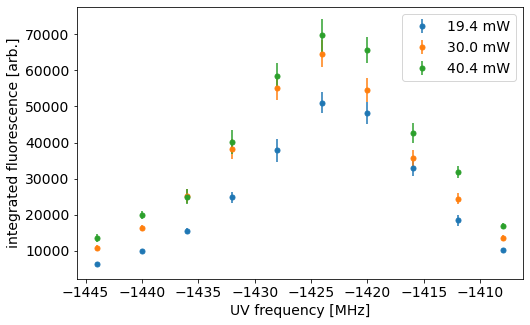

In [78]:
fig, ax = plt.subplots(figsize = (8,5))

for power in sorted(powers):
    bins, values, err = scan_data[power]
    ax.errorbar(4*bins, values, yerr = err, fmt = '.', label = f'{power:.1f} mW', ms = 10)

    ax.legend(fontsize = 14)
    
ax.set_xlabel('UV frequency [MHz]')
ax.set_ylabel('integrated fluorescence [arb.]')

set_fontsize(ax, 14)

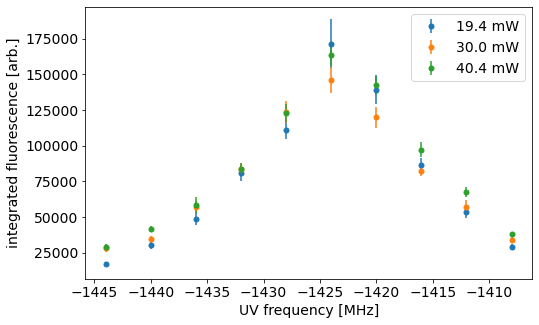

In [79]:
fig, ax = plt.subplots(figsize = (8,5))

for power in sorted(powers):
    bins, values, err = scan_data_normalized[power]
    ax.errorbar(4*bins, values, yerr = err, fmt = '.', label = f'{power:.1f} mW', ms = 10)

    ax.legend(fontsize = 14)
    
ax.set_xlabel('UV frequency [MHz]')
ax.set_ylabel('integrated fluorescence [arb.]')

set_fontsize(ax, 14)

## Looking at a single dataset of the data above

In [81]:
det_name = dset_names[-2]
print(det_name)

1612318033 moved det to center saturation scan 40.4 mW


In [82]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(fname, dset_name, devices)

freq_data = np.array([pxie_attrs[idx][freq_attr] for idx in range(1,len(pxie)+1)])

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
norm_data = -pd_data/pdn_data

In [108]:
dat = pmt_data[np.where(freq_data == -357)[0],:].copy()
dat -= np.mean(dat[:,100:250], axis = 1)[:, np.newaxis]
dat = dat.reshape(-1,nbunch,dset_len)

In [126]:
np.nanargmax(np.trapz(dat.mean(axis = 1), axis = 1))

36

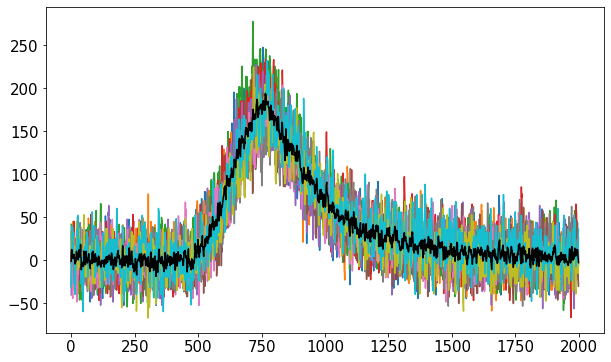

In [136]:
idx = 5
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(dat[idx,:,:].T);
ax.plot(dat.mean(axis = 1)[idx], color = 'k')
set_fontsize(ax, 15)

In [83]:
pmt_data[np.where(yag_data.max(axis = 1) < 500)[0]] = np.nan
norm_data[np.where(yag_data.max(axis = 1) < 500)[0]] = np.nan

pmt_data_avg = np.nanmean(pmt_data.reshape(-1,nbunch,dset_len), axis = 1)
norm_data_avg = np.nanmean(norm_data.reshape(-1,nbunch,dset_len), axis = 1)

pmt_data_avg -= pmt_data_avg[:,100:250].mean(axis = 1)[:,np.newaxis]
norm_data_avg -= norm_data_avg[:,-750:].mean(axis = 1)[:,np.newaxis]

freq_data_avg = freq_data.reshape(-1,nbunch).mean(axis = 1)

fluorescence_integral = np.trapz(pmt_data_avg[:,100:], axis = 1)
absorption_integral = np.trapz(norm_data_avg[:,10:1250], axis = 1)

<ipython-input-83-6a15a5e77f59>:4: RuntimeWarning: Mean of empty slice
  pmt_data_avg = np.nanmean(pmt_data.reshape(-1,nbunch,dset_len), axis = 1)
<ipython-input-83-6a15a5e77f59>:5: RuntimeWarning: Mean of empty slice
  norm_data_avg = np.nanmean(norm_data.reshape(-1,nbunch,dset_len), axis = 1)


Text(0.5, 0, 'uv frequency [MHz]')

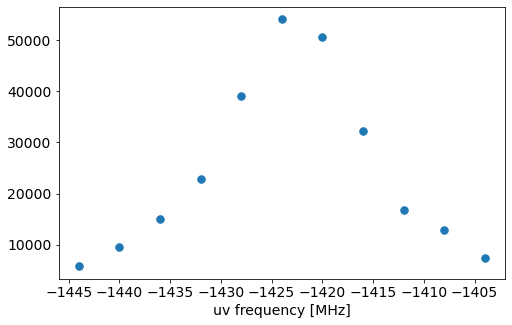

In [84]:
bin_fun = lambda x: np.nanmean(x)
bins = np.arange(-362,351,1)
stat, bin_edges, bin_number = binned_statistic(freq_data_avg, fluorescence_integral, statistic = bin_fun, bins = bins)

bin_means = bin_edges[:-1]+np.diff(bin_edges)[0]

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(bin_means*4, stat, '.', ms = 15)
set_fontsize(ax, 14)
ax.set_xlabel('uv frequency [MHz]')

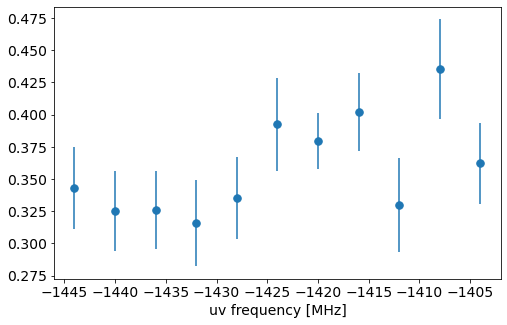

In [85]:
stat, bin_edges, bin_number = binned_statistic(freq_data_avg, absorption_integral, statistic = bin_fun, bins = bins)
std, bin_edges, bin_number = binned_statistic(freq_data_avg, absorption_integral, statistic = lambda x: np.nanstd(x)/np.sqrt(len(x)), bins = bins)

bin_means = bin_edges[:-1]+np.diff(bin_edges)[0]

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means*4, stat, yerr = std, fmt = '.', ms = 15)
ax.set_xlabel('uv frequency [MHz]')

set_fontsize(ax, 14)

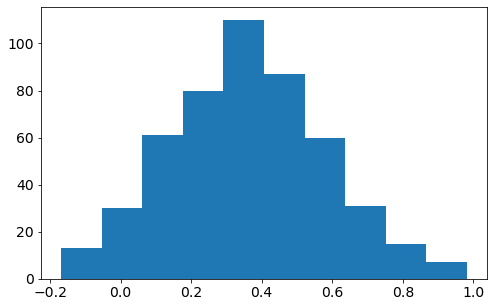

In [86]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hist(absorption_integral)
set_fontsize(ax, 14)

In [87]:
absorption_cutoff = 1
mean = np.nanmean(absorption_integral)
std = np.nanstd(absorption_integral)
mask_absorption = (absorption_integral > mean - absorption_cutoff*std) \
                    & (absorption_integral < mean + absorption_cutoff*std)

print(f"filtered out {100 - mask_absorption.sum()/len(mask_absorption)*100:.2f}%")

filtered out 34.95%


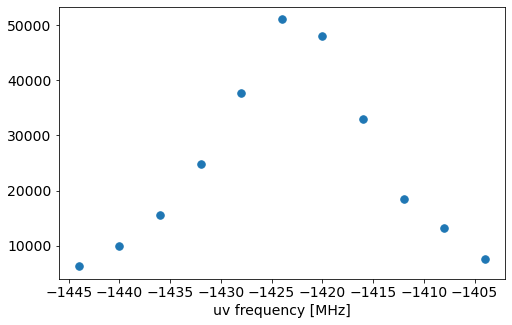

In [92]:
bin_fun = lambda x: np.nanmean(x)
stat, bin_edges, bin_number = binned_statistic(freq_data_avg[mask_absorption], 
                                               fluorescence_integral[mask_absorption], 
                                               statistic = bin_fun, 
                                               bins = bins)

bin_means = bin_edges[:-1]+np.diff(bin_edges)[0]

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(bin_means*4, stat, '.', ms = 15)

ax.set_xlabel('uv frequency [MHz]')
set_fontsize(ax, 14)

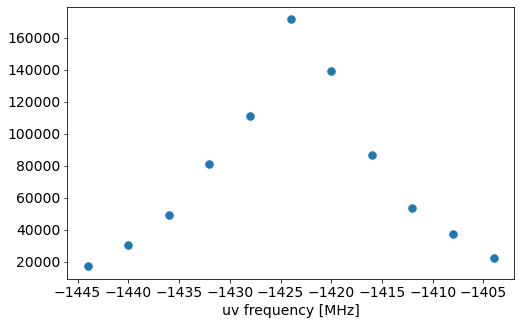

In [91]:
bin_fun = lambda x: np.nanmean(x)
stat, bin_edges, bin_number = binned_statistic(freq_data_avg[mask_absorption], 
                                               fluorescence_integral[mask_absorption]/absorption_integral[mask_absorption], 
                                               statistic = bin_fun, 
                                               bins = bins)

bin_means = bin_edges[:-1]+np.diff(bin_edges)[0]

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(bin_means*4, stat, '.', ms = 15)

ax.set_xlabel('uv frequency [MHz]')
set_fontsize(ax, 14)